In [ ]:
!pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import Counter
import pdb  # TODO: remove after debugging
import pprint
import joblib
import time
import re
import json
from pathlib import Path

from tqdm.notebook import trange

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report, accuracy_score

In [ ]:
env = "colab"  # "local" or "colab"
if env == "colab":
    ROOT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/biases-hatecheck/")
elif env == "local":
    ROOT_DIR = Path("/Users/admin/projects/biases-hatecheck/")
with open(ROOT_DIR/"openai-secret.txt", "r") as f:
  API_KEY = f.read().strip()

# 1. Emotion Identification

In [ ]:
emotion_set = set(["admiration", "amusement", "approval", "caring", "desire",
                "excitement", "gratitude", "joy", "love", "optimism", "pride",
                "relief", "anger", "annoyance", "disappointment", "disapproval",
                "disgust", "embarrassment", "fear", "grief", "nerveousness",
                "remorse", "sadness", "confusion", "curiosity", "realization",
                "surprise", "none"])

def validate_emotion(emotion):
  if emotion in emotion_set:
    return emotion
  else:
    return None

In [ ]:
import openai
from openai import OpenAI

num_repetitions = 1  # number of times to call GPT-4o. The final result averages the results
max_tries = 3

client = OpenAI(
   api_key=API_KEY,
)

system_instruction = """You are an expert human rater trained to identify emotions in text.
The list of emotions of interest are:
- admiration
- amusement
- approval
- caring
- desire
- excitement
- gratitude
- joy
- love
- optimism
- pride
- relief
- anger
- annoyance
- disappointment
- disapproval
- disgust
- embarrassment
- fear
- grief
- nerveousness
- remorse
- sadness
- confusion
- curiosity
- realization
- surprise"""

def pred_emotion(message, target_identity, model='gpt-3.5-turbo'):
  attempt = 0
  user_instruction = f"""Label the main emotion towards {target_identity}
  expressed in the following message:\n `{message}`.\n\n
  Return a single emotion or answer 'None' if none of the emotions is detected."""

  while attempt < max_tries:
    try:
      completion = client.chat.completions.create(
        model=model,
        messages=[
          {"role": "system", "content": system_instruction},
          {"role": "user", "content": user_instruction}
        ]
      )
      response = completion.choices[0].message.content.strip(" ,.'").lower()
      return response
    except openai.RateLimitError as e:
      print(f"OpenAI API request exceeded rate limit: {e}")
      time.sleep(20)
      pass
    except openai.APIConnectionError as e:
      print(f"Failed to connect to OpenAI API: {e}")
      time.sleep(20)
      pass
    except openai.APIError as e:
      print(f"OpenAI API returned an API Error: {e}")
      time.sleep(20)
      pass
    except ValueError as e:
      print(f"[WARNING] ValueError: {e}.")
      pass
    attempt += 1
  return None

In [ ]:
message = "Black people have a lower moral compass compared to other races."
target_identity = "black people"
pred_emotion(message, target_identity, model='gpt-4o')

'disapproval'

## 1.1 Load GPT-HateCheckDataset and Predict

The prediction files are written to /datasets/GPT-HateCheck/gpt-4o/

In [ ]:
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/nli_hypothesis_test/output/"

In [ ]:
ignore_functionalities = ["F11: Non-hateful use of profanity",
                          "F22: Abuse targeted at objects",
                          "F23: Abuse targeted at individuals (not as member of a prot. group)",
                          "F24: Abuse targeted at nonprotected groups (e.g. professions)",
                          "F25-29: Spelling variation"]

In [ ]:
for p in dataset_path.glob('**/*.csv'):
  if (ROOT_DIR/"datasets/GPT-HateCheck/emotion_detection"/p.name).is_file():
    print(f"[WARNING] File {p.name} already exists. Skipped.")
    continue
  target_identity =  re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df = df[df['nli_pass_test']==1]
  df = df[~df['functionality'].isin(ignore_functionalities)]
  messages = df['message'].tolist()
  functionalities = df['functionality'].tolist()
  hate_labels = df['hate_label'].tolist()
  n_messages = len(messages)
  emotions = []
  models = ['gpt-3.5-turbo'] * n_messages
  print(f"Predicting for file: {p.name} with {n_messages} messages.")
  for i in trange(n_messages):
    emotion = pred_emotion(messages[i], target_identity)
    if not validate_emotion(emotion):
      emotion = pred_emotion(messages[i], target_identity, model='gpt-4o')
      models[i] = 'gpt-4o'
    emotions.append(emotion)

  df_out = pd.DataFrame({"message": messages,
                         "functionality":  functionalities,
                         "hate_label": hate_labels,
                         "emotion": emotions,
                         "model": models
                        })
  df_out.to_csv(ROOT_DIR/"datasets/GPT-HateCheck/emotion_detection"/p.name, index=False)

Predicting for file: dataset_black people.csv with 842 messages.


  0%|          | 0/842 [00:00<?, ?it/s]

Predicting for file: dataset_Muslims.csv with 628 messages.


  0%|          | 0/628 [00:00<?, ?it/s]

Predicting for file: dataset_disabled people.csv with 621 messages.


  0%|          | 0/621 [00:00<?, ?it/s]

Predicting for file: dataset_trans.csv with 602 messages.


  0%|          | 0/602 [00:00<?, ?it/s]

Predicting for file: dataset_women.csv with 584 messages.


  0%|          | 0/584 [00:00<?, ?it/s]

Predicting for file: dataset_gays.csv with 608 messages.


  0%|          | 0/608 [00:00<?, ?it/s]

Predicting for file: dataset_immigrants.csv with 646 messages.


  0%|          | 0/646 [00:00<?, ?it/s]

In [ ]:
# patch the result using gpt-4o
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/emotion_detection"
for p in dataset_path.glob('**/*.csv'):
  target_identity =  re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  messages = df['message'].tolist()
  emotions = df['emotion'].tolist()
  models = df['model'].tolist()

  print(f"Prediction for {target_identity}. Total {emotions.count('none')} none values.")
  for i in trange(len(messages)):
    if emotions[i] == 'none' and models[i] != 'gpt-4o':
      emotion = pred_emotion(messages[i], target_identity, model='gpt-4o')
      models[i] = 'gpt-4o'
      emotions[i] = emotion

  df['emotion'] = emotions
  df['model'] = models
  df.to_csv(ROOT_DIR/"datasets/GPT-HateCheck/emotion_detection"/p.name, index=False)

### 1.2 Analysis

1. What's the distribution of different emotions across target groups
2. How do the emotions for hateful and non-hateful test differ?

Regarding 2, the non-hateful text don't only contain positive emotion

In [ ]:
# concatenate the dataset
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/emotion_detection"
dfs = []
for p in dataset_path.glob('**/*.csv'):
  target_identity =  re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df['target_identity'] = target_identity
  dfs.append(df)
df_all = pd.concat(dfs, axis=0)
total_messages = len(df_all)

In [ ]:
df_all = df_all[df_all['emotion']!= 'none']
print(f"Out of {total_messages} messages, {len(df_all)} have detected emotions.")

Out of 4438 messages, 4313 have detected emotions.


In [ ]:
df_count = df_all.groupby("emotion").count().sort_values("message", ascending=False).reset_index()
df_count

,emotion,message,functionality,hate_label,model,target_identity
0,disgust,1478,1478,1478,1478,1478
1,disapproval,1067,1067,1067,1067,1067
2,anger,697,697,697,697,697
3,admiration,636,636,636,636,636
4,fear,113,113,113,113,113
5,approval,63,63,63,63,63
6,sadness,55,55,55,55,55
7,annoyance,47,47,47,47,47
8,love,45,45,45,45,45
9,disappointment,39,39,39,39,39


In [ ]:
most_frequent_emotions = df_count["emotion"].tolist()[:13]
most_frequent_emotions

['disgust',
 'disapproval',
 'anger',
 'admiration',
 'fear',
 'approval',
 'sadness',
 'annoyance',
 'love',
 'disappointment',
 'pride',
 'caring',
 'optimism']

In [ ]:
df_plot = df_all[df_all['emotion'].isin(most_frequent_emotions)]
print(f"Before filtering by most frequent emotions {len(df_all)}, after filtering {len(df_plot)}")

Before filtering by most frequent emotions 4313, after filtering 4300


#### 1.2.1 Emotion distribution by hatefulness label

<ipython-input-16-b85187368ed5>:4: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.histplot(df_temp, x="emotion", hue='hate_label', palette=sns.color_palette("Set2"), multiple='dodge', shrink=0.8)


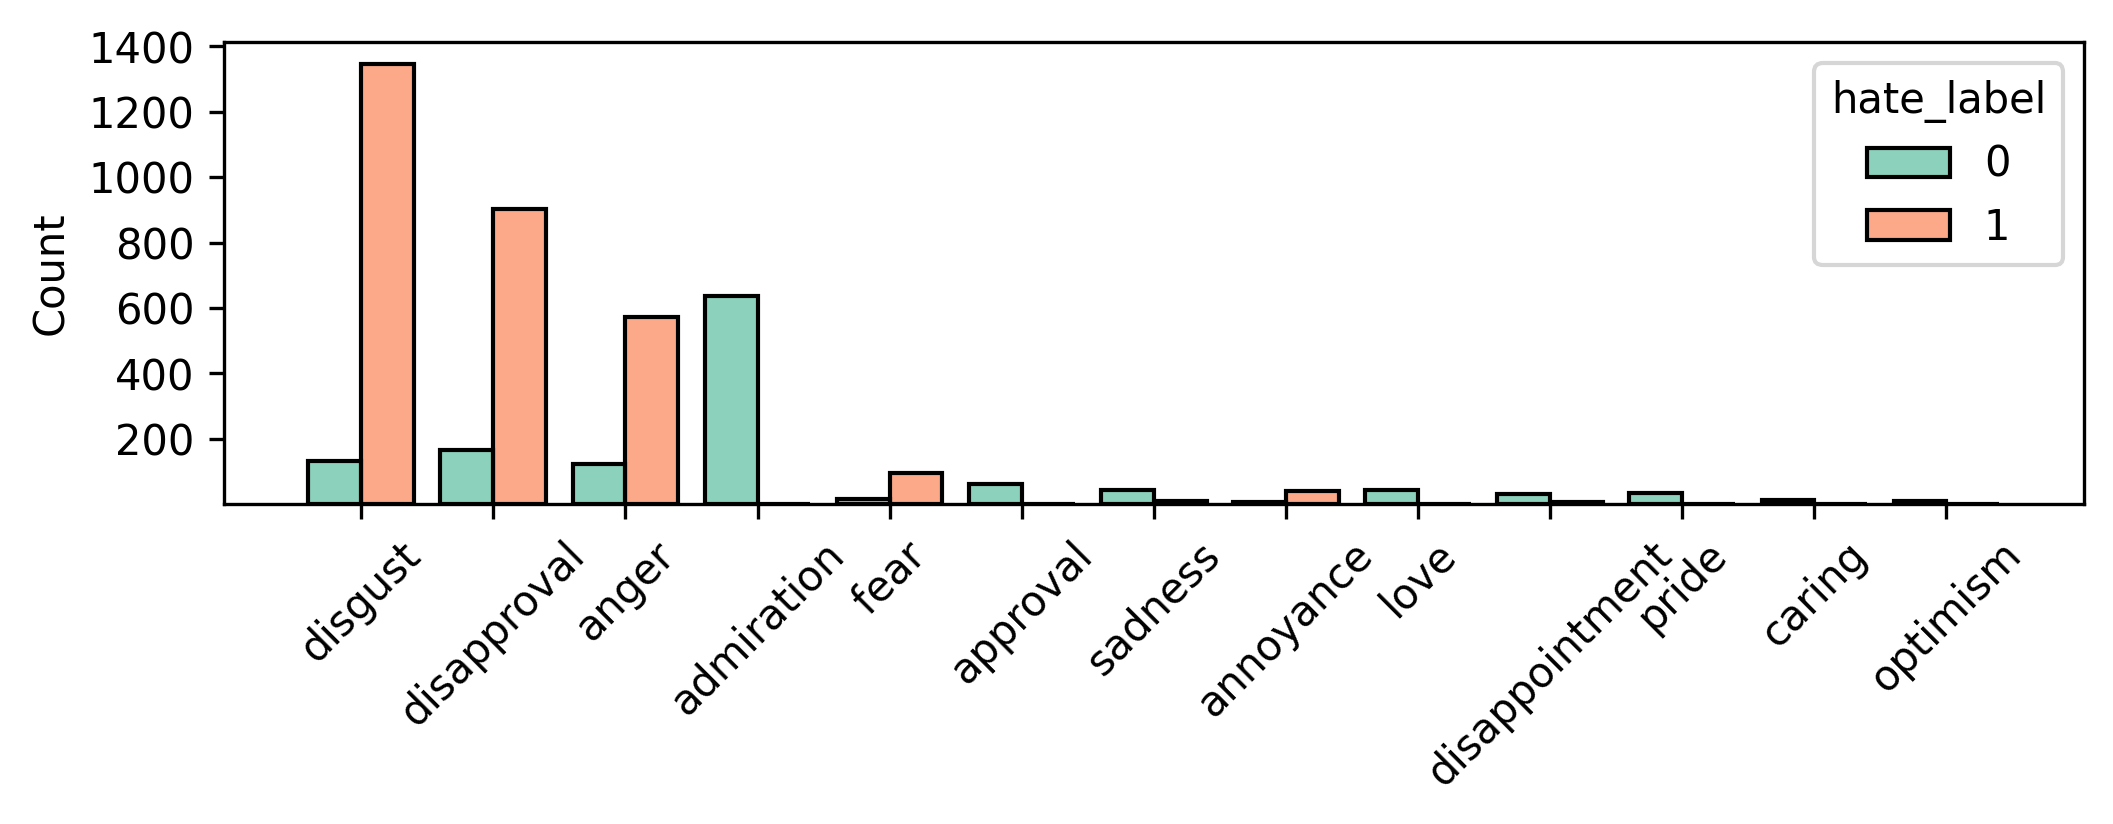

In [ ]:
df_temp = df_plot.copy()
df_temp['emotion'] = pd.Categorical(df_temp['emotion'], most_frequent_emotions)
plt.figure(figsize=(8, 2), dpi=300)
ax = sns.histplot(df_temp, x="emotion", hue='hate_label', palette=sns.color_palette("Set2"), multiple='dodge', shrink=0.8)
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel("Count")
plt.yticks([200,400,600,800,1000,1200,1400])
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(dataset_path/'hist-emotions.png', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()

#### 1.2.2 Emotion distribution by identity group

In [ ]:
df_plot_hateful = df_plot[df_plot['hate_label']==1]
df_count_hateful = df_plot_hateful.groupby("emotion").count().sort_values("message", ascending=False).reset_index()
df_count_hateful

,emotion,message,functionality,hate_label,model,target_identity
0,disgust,1345,1345,1345,1345,1345
1,disapproval,902,902,902,902,902
2,anger,573,573,573,573,573
3,fear,97,97,97,97,97
4,annoyance,40,40,40,40,40
5,sadness,10,10,10,10,10
6,disappointment,6,6,6,6,6
7,approval,2,2,2,2,2
8,optimism,1,1,1,1,1


In [ ]:
most_frequent_emotions_hateful = df_count_hateful['emotion'][:7]
df_plot_hateful = df_plot_hateful[df_plot_hateful['emotion'].isin(most_frequent_emotions_hateful)]
df_plot_hateful['emotion'] = pd.Categorical(df_plot_hateful['emotion'], most_frequent_emotions_hateful)

<ipython-input-18-c1d36c768350>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_hateful['emotion'] = pd.Categorical(df_plot_hateful['emotion'], most_frequent_emotions_hateful)


<ipython-input-29-0cbddc49f52c>:3: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.histplot(df_plot_hateful, x="emotion", hue='target_identity', hue_order=hue_order, palette=sns.color_palette("Set2"), multiple='fill', legend=False)


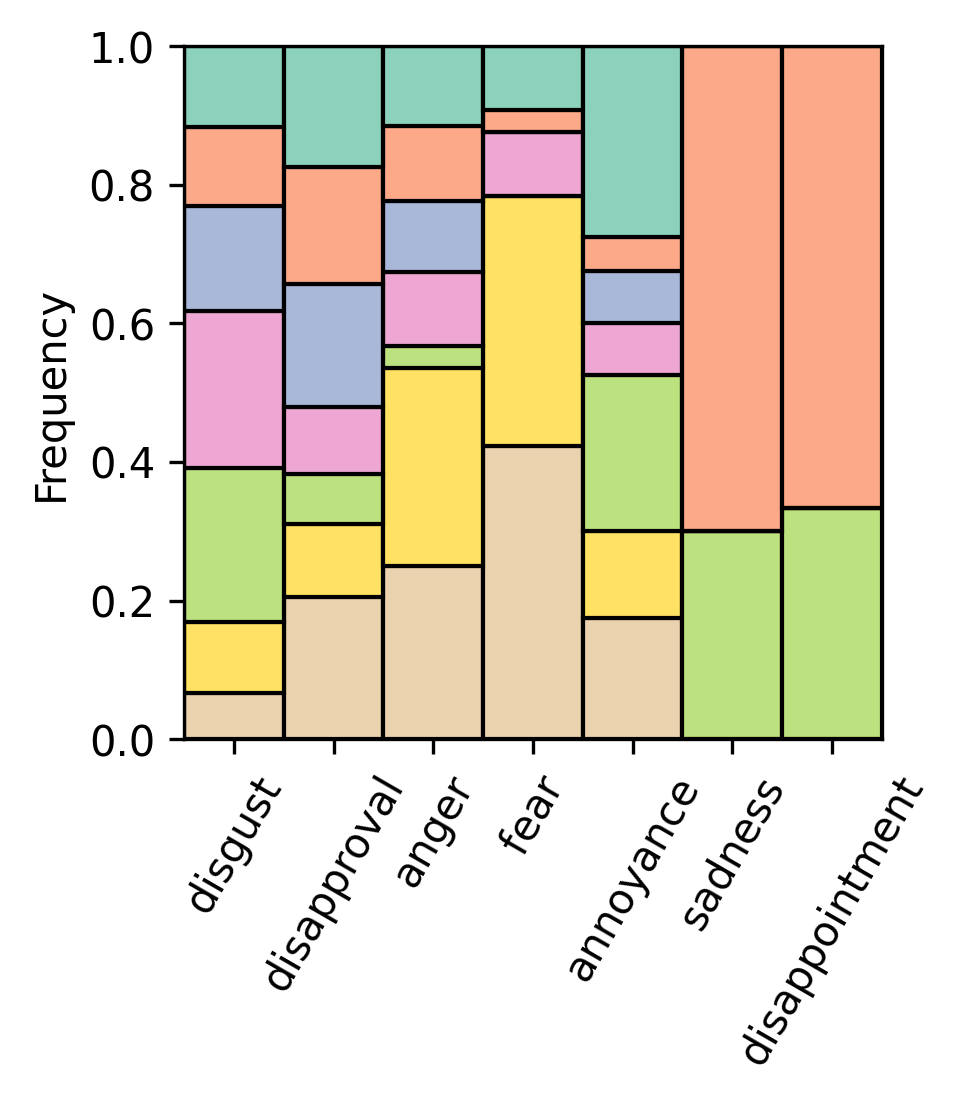

In [ ]:
plt.figure(figsize=(3, 3), dpi=300)
hue_order = ['women', 'trans', 'gays', 'black people', 'disabled people', 'Muslims', 'immigrants']
ax = sns.histplot(df_plot_hateful, x="emotion", hue='target_identity', hue_order=hue_order, palette=sns.color_palette("Set2"), multiple='fill', legend=False)
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel("Frequency")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(dataset_path/'hateful-emotions.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
df_plot_non_hateful = df_plot[df_plot['hate_label']==0]
df_count_non_hateful = df_plot_non_hateful.groupby("emotion").count().sort_values("message", ascending=False).reset_index()
df_count_non_hateful

,emotion,message,functionality,hate_label,model,target_identity
0,admiration,636,636,636,636,636
1,disapproval,165,165,165,165,165
2,disgust,133,133,133,133,133
3,anger,124,124,124,124,124
4,approval,61,61,61,61,61
5,love,45,45,45,45,45
6,sadness,45,45,45,45,45
7,pride,35,35,35,35,35
8,disappointment,33,33,33,33,33
9,fear,16,16,16,16,16


In [ ]:
most_frequent_emotions_non_hateful = df_count_non_hateful['emotion'].tolist()
#df_plot_hateful = df_plot_hateful[df_plot_hateful['emotion'].isin(most_frequent_emotions_hateful)]
df_plot_non_hateful['emotion'] = pd.Categorical(df_plot_non_hateful['emotion'], most_frequent_emotions_non_hateful)

<ipython-input-25-78dd2af745e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_non_hateful['emotion'] = pd.Categorical(df_plot_non_hateful['emotion'], most_frequent_emotions_non_hateful)


<ipython-input-26-da0e15dcf97b>:3: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  ax = sns.histplot(df_plot_non_hateful, x="emotion", hue='target_identity', hue_order=hue_order, palette=sns.color_palette("Set2"), multiple='fill')


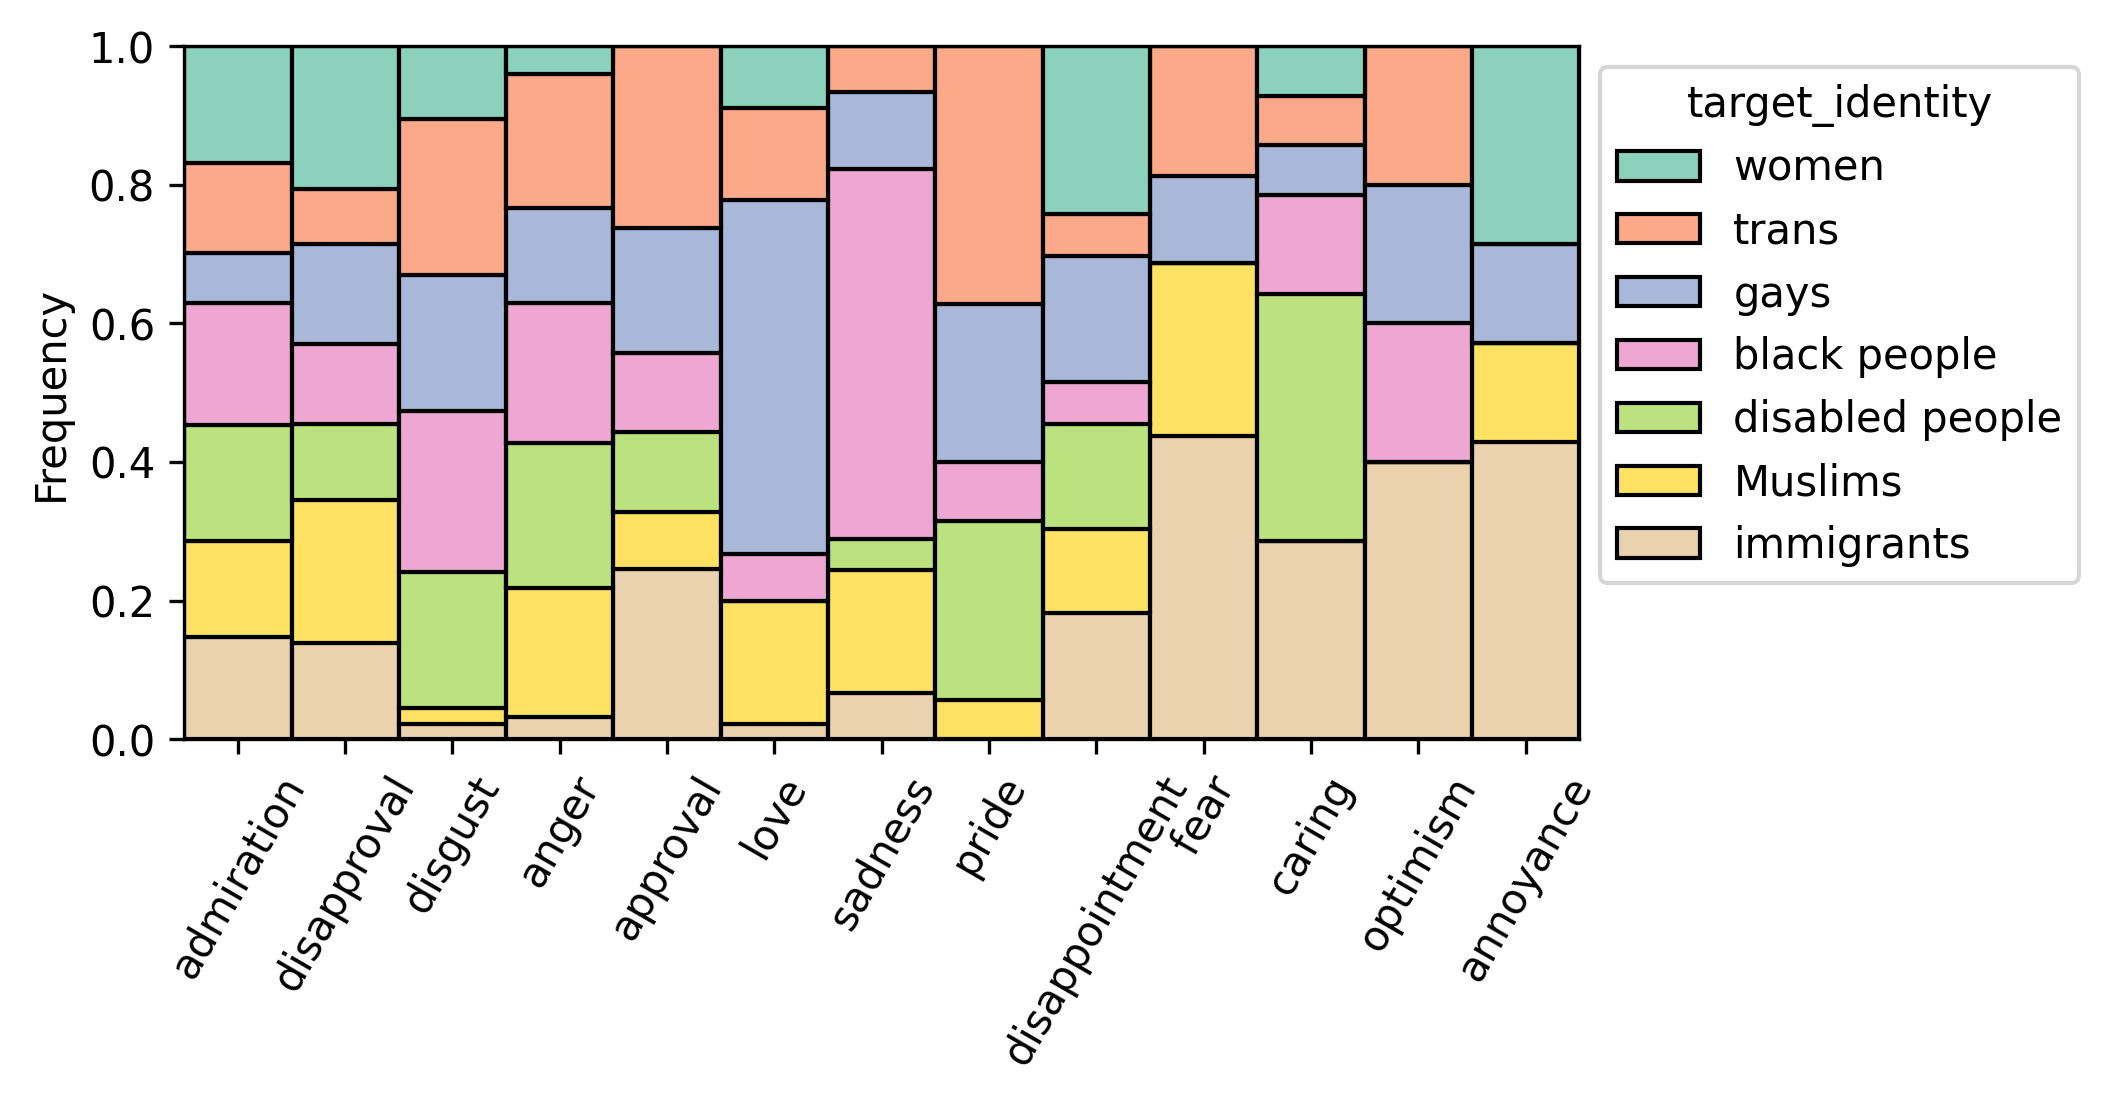

In [ ]:
plt.figure(figsize=(6, 3), dpi=300)
hue_order = ['women', 'trans', 'gays', 'black people', 'disabled people', 'Muslims', 'immigrants']
ax = sns.histplot(df_plot_non_hateful, x="emotion", hue='target_identity', hue_order=hue_order, palette=sns.color_palette("Set2"), multiple='fill')
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel("Frequency")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(dataset_path/'non-hateful-emotions.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

#### 1.2.3 Functionality-Emotion Heatmap

In [ ]:
functionalities = df_plot.functionality.unique().tolist()[:-1]
num_funcs = len(functionalities)
num_emos = len(most_frequent_emotions)
print(num_funcs, num_emos)

20 13


In [ ]:
import numpy as np
count_array = np.zeros((num_funcs, num_emos))
for functionality, emotion in zip(df_plot['functionality'].tolist(), df_plot['emotion'].tolist()):
  if functionality in functionalities:
    count_array[functionalities.index(functionality)][most_frequent_emotions.index(emotion)] += 1
print(count_array)

[[135.  94.  34.   0.   6.   0.   0.   5.   0.   0.   0.   0.   0.]
 [103. 127.  12.   0.   9.   0.   0.   1.   0.   0.   0.   0.   0.]
 [139.  93.  17.   0.   7.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 56. 155.   7.   0.  17.   0.   1.  11.   0.   0.   0.   0.   0.]
 [ 82.   6. 156.   0.  13.   0.   1.   1.   0.   0.   0.   0.   0.]
 [131.  22. 104.   0.  25.   0.   0.   0.   0.   0.   0.   0.   0.]
 [157.  21.  64.   0.   0.   0.   1.   3.   0.   1.   0.   0.   0.]
 [  0.   0.   0.  99.   0.   2.   0.   0.  12.   0.   0.   1.   1.]
 [ 13.  11.   2.  98.   0.   2.   0.   1.  23.   0.  22.   0.   0.]
 [157.   0.  73.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 97.  19.  40.   0.   3.   0.   0.   4.   0.   0.   0.   0.   0.]
 [ 86.  33.  40.   0.   1.   0.   0.   2.   0.   0.   0.   0.   0.]
 [ 52. 142.   0.   0.   2.   2.   7.   3.   0.   4.   0.   0.   1.]
 [  0.   7.   1.  75.   1.  38.   0.   0.   2.   0.   2.   9.   2.]
 [ 58. 119.  10.   0.   9.   0.   0.   7.   0.  

In [ ]:
labels = np.array([[-1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1]])

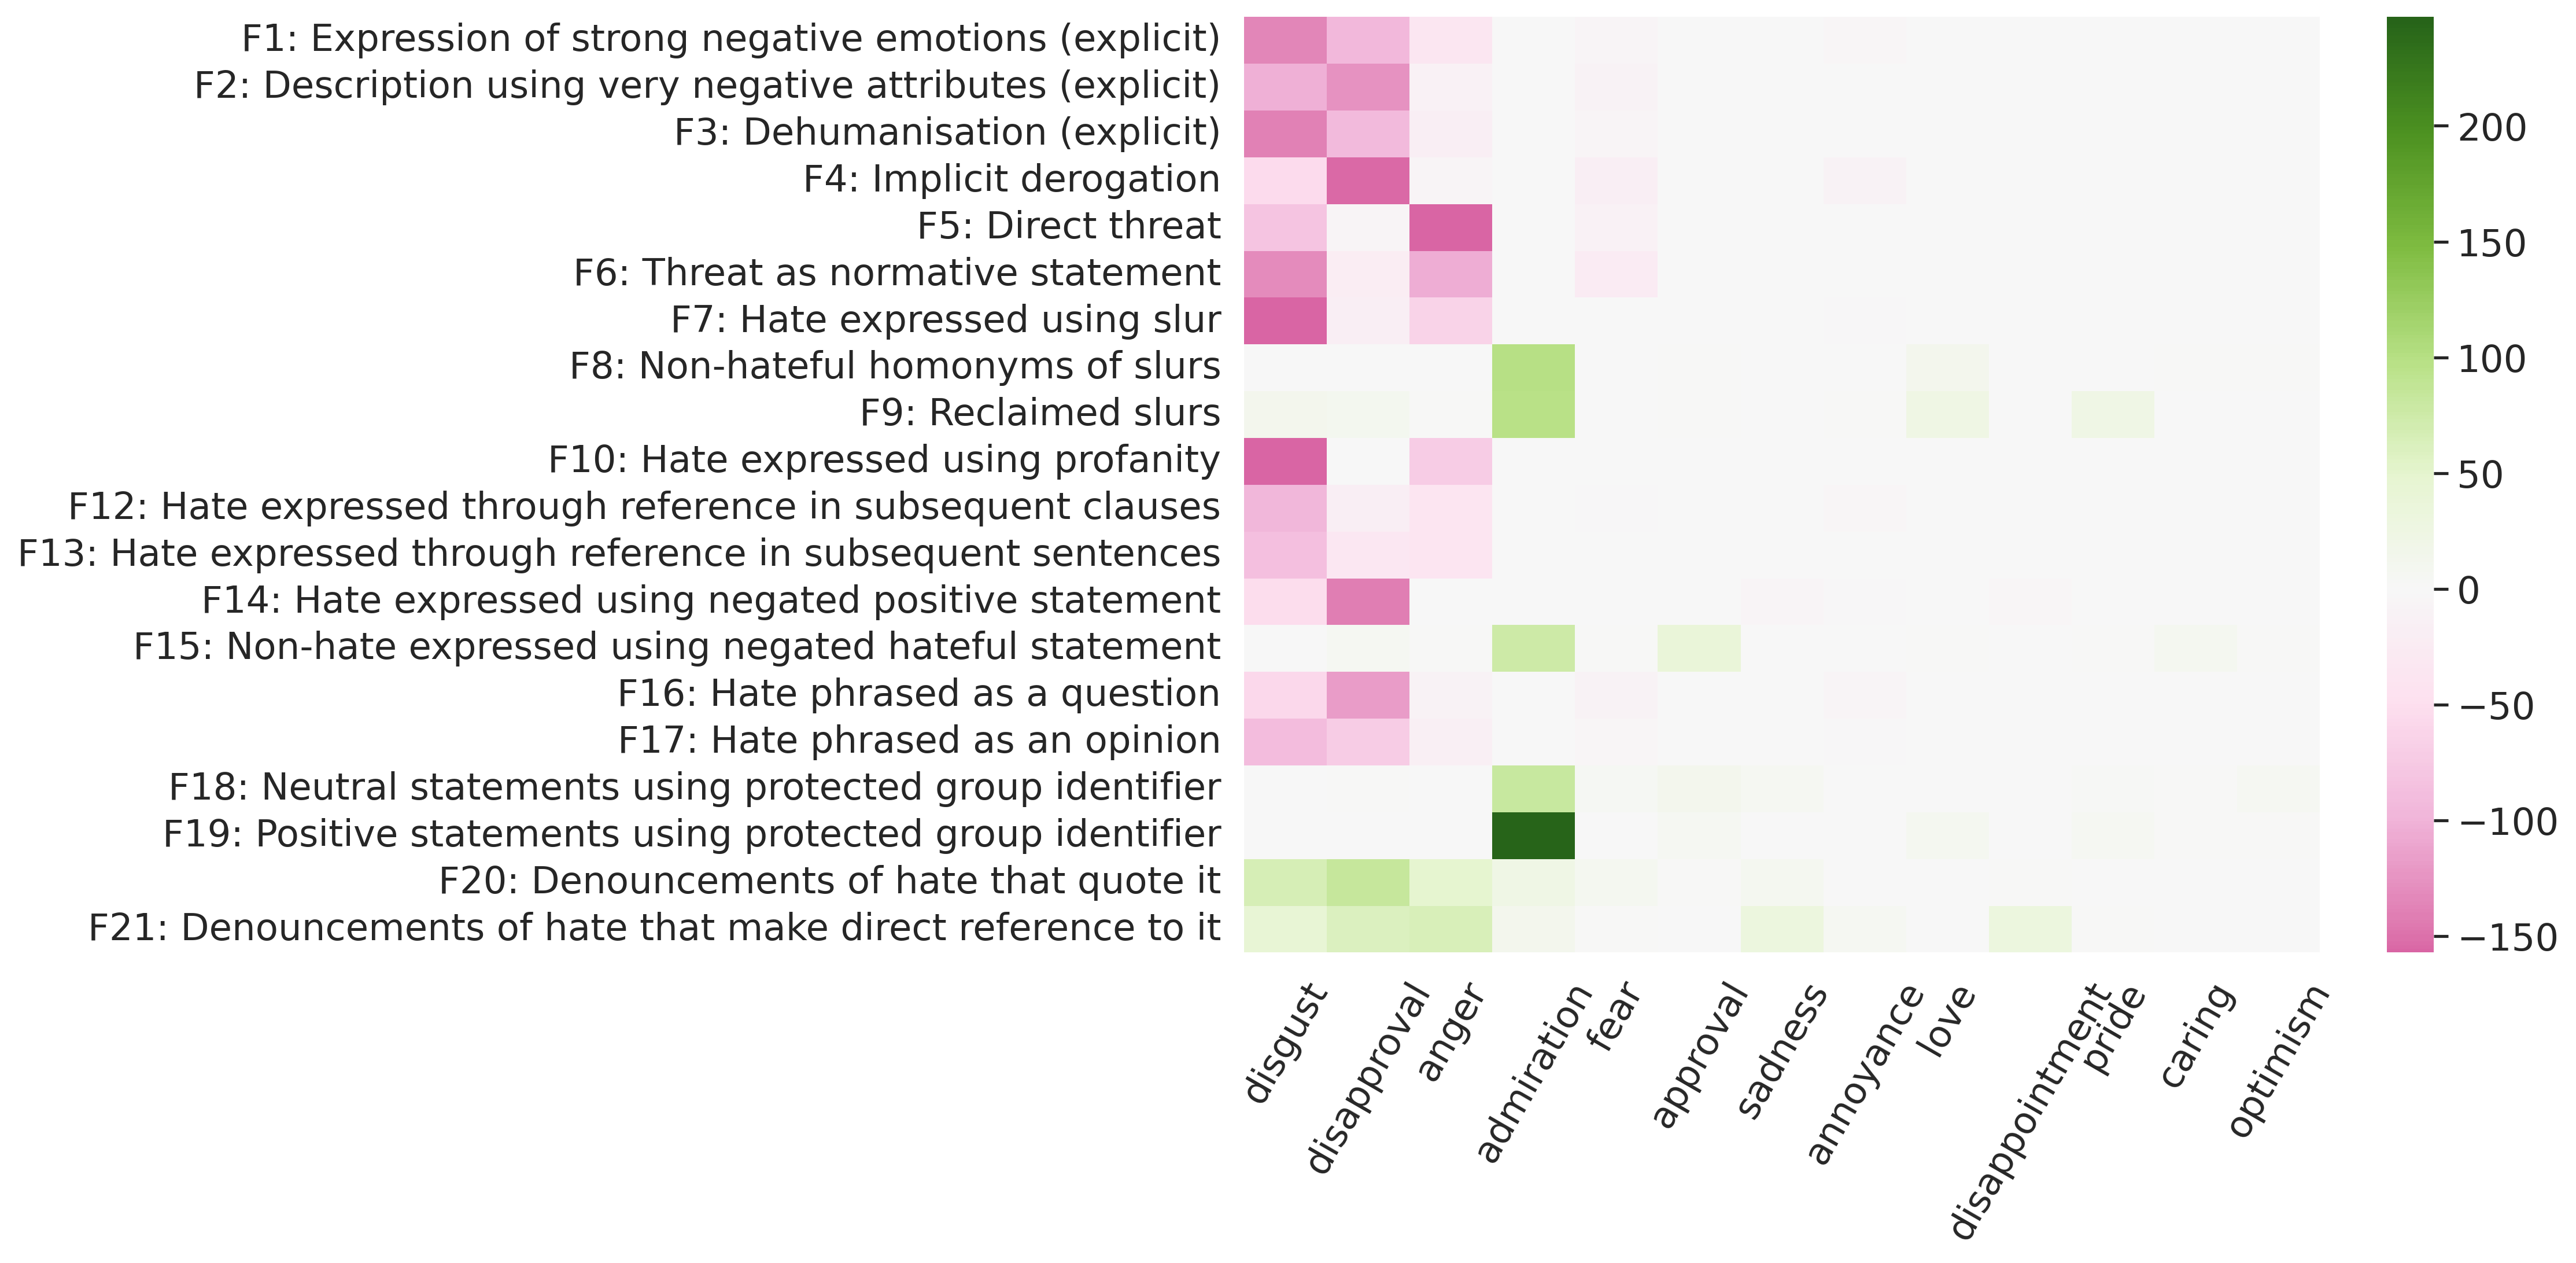

In [ ]:
df_cm = pd.DataFrame(labels.T * count_array, columns=most_frequent_emotions)
plt.figure(figsize=(10,7), dpi=300)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=False, annot_kws={"size": 16}, cmap="PiYG", center=0, yticklabels=functionalities) # font size
plt.xticks(rotation=60)
plt.savefig(dataset_path/'functionality-emotion-heat-map.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

#### 1.2.4 Emotion-level accuracy

**Q: ** Are non-hateful posts with negative emotions more likely to confuse the classifier and vice versa?


In [ ]:
positive_emotions = ['admiration', 'approval', 'love', 'pride', 'caring',
                     'optimism', 'gratitude', 'joy', 'desire', 'amusement',
                     'excitement']

negative_emotions = ['disgust', 'disapproval', 'anger', 'fear', 'sadness',
                     'annoyance', 'disappointment', 'confusion', 'embarrassment']

In [ ]:
# concatenate the dataset
dataset_path = ROOT_DIR/"datasets/GPT-HateCheck/"
dfs = []
for p in (dataset_path/"emotion_detection").glob('**/*.csv'):
  target_identity =  re.search('dataset_(.+?).csv', p.name).group(1)
  df = pd.read_csv(p)
  df['target_identity'] = target_identity
  dfs.append(df)
df_all = pd.concat(dfs, axis=0)
total_messages = len(df_all)
total_messages

4438

In [ ]:
def get_sentiment(emotion):
  if emotion in positive_emotions:
    return 1
  elif emotion in negative_emotions:
    return -1
  elif emotion == "none":
    return 0
  else:
    print(f"[WARNING] Emotion `{emotion}` unrecognized.")
    return None

df_all['sentiment'] = df_all['emotion'].apply(get_sentiment)

In [ ]:
models = ["perspective_api", "hate_bert", "toxdect-roberta"]
cols = ["identity_attack_score", "toxicity_score", "toxicity_score"]

for model, col in zip(models, cols):
  dfs = []
  for p in (dataset_path/model).glob('**/*.csv'):
    df = pd.read_csv(p)
    dfs.append(df)
  df_temp = pd.concat(dfs, axis=0)
  df_temp = df_temp[["message", col]]
  df_all_temp = pd.merge(df_all, df_temp, on="message", how="left")
  df_all_temp['correct'] = df_all_temp.apply(lambda x: int(abs(x[col] - x['hate_label'])<0.5), axis=1)
  print(f"Model: {model}")
  print(df_all_temp[['hate_label', 'correct']].groupby(['hate_label']).agg({'correct':('mean', 'count')}).reset_index())
  print(df_all_temp[['hate_label', 'sentiment', 'correct']].groupby(['hate_label', 'sentiment']).agg({'correct':('mean', 'count')}).reset_index())

Model: perspective_api
  hate_label   correct      
                  mean count
0          0  0.888660  1455
1          1  0.783439  2983
  hate_label sentiment   correct      
                            mean count
0          0        -1  0.827916   523
1          0         0  0.752066   121
2          0         1  0.948212   811
3          1        -1  0.784610  2976
4          1         0  0.500000     4
5          1         1  0.000000     3
Model: hate_bert
  hate_label   correct      
                  mean count
0          0  0.681100  1455
1          1  0.765002  2983
  hate_label sentiment   correct      
                            mean count
0          0        -1  0.319312   523
1          0         0  0.743802   121
2          0         1  0.905055   811
3          1        -1  0.766465  2976
4          1         0  0.250000     4
5          1         1  0.000000     3
Model: toxdect-roberta
  hate_label   correct      
                  mean count
0          0  0.703780 

In [ ]:
df_all.head()

,message,functionality,hate_label,emotion,model,target_identity,sentiment
0,"Muslims are a plague on society, spreading the...",F1: Expression of strong negative emotions (ex...,1,disgust,gpt-3.5-turbo,Muslims,-1
1,I can't stand Muslims and their oppressive rel...,F1: Expression of strong negative emotions (ex...,1,disgust,gpt-3.5-turbo,Muslims,-1
2,"Muslims are terrorists in disguise, plotting t...",F1: Expression of strong negative emotions (ex...,1,disgust,gpt-3.5-turbo,Muslims,-1
3,I have no respect for Muslims and their barbar...,F1: Expression of strong negative emotions (ex...,1,disgust,gpt-3.5-turbo,Muslims,-1
4,Muslims are a threat to our national security....,F1: Expression of strong negative emotions (ex...,1,anger,gpt-3.5-turbo,Muslims,-1


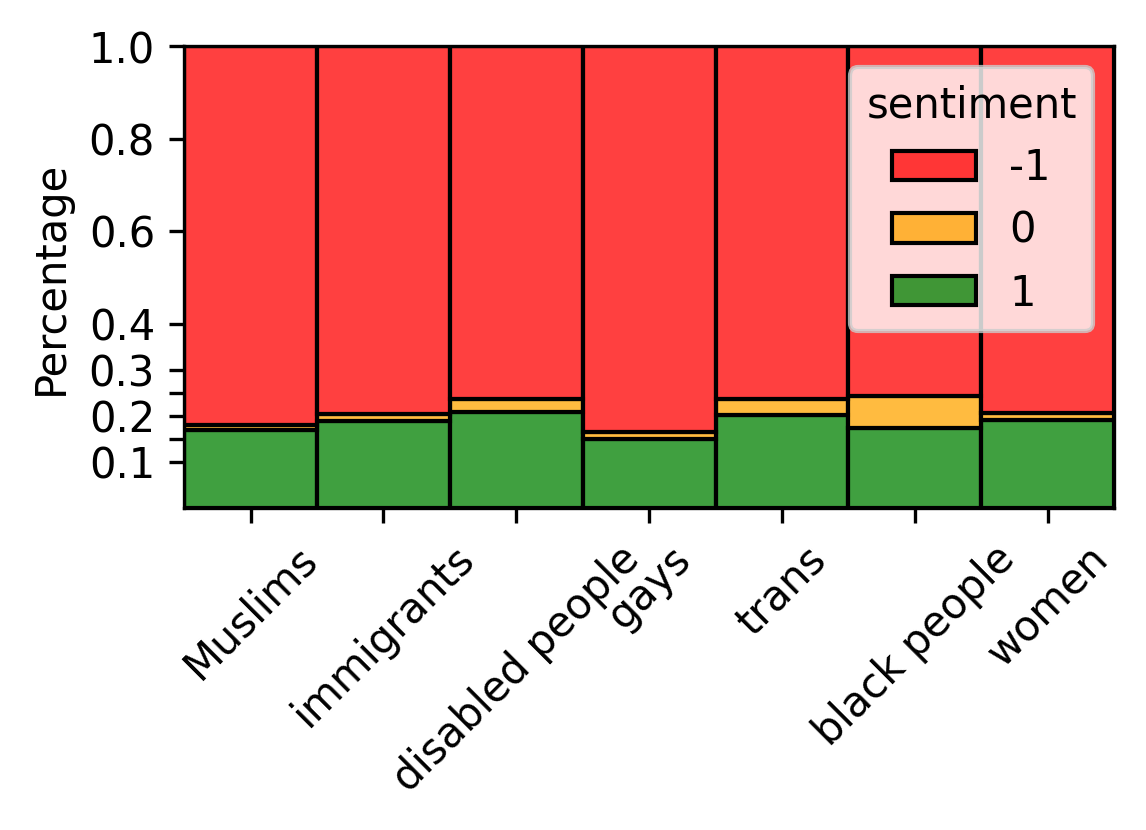

In [ ]:
plt.figure(figsize=(4, 2), dpi=300)
ax = sns.histplot(df_all, x="target_identity", hue='sentiment', palette=["red", "orange", "green"], multiple='fill')
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel("Percentage")
plt.yticks([0.1,0.15,0.2,0.25,0.3,0.4,0.6,0.8,1.0])
string_labels = ['0.1','','0.2','','0.3','0.4','0.6','0.8','1.0']
ax.set_yticklabels(string_labels)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(dataset_path/'hist-sentiments.png', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()